# ARPA Lombardia Ground Sensors data request notebook

This notebook is used to download data from both meteorological and air quality ground sensor of ARPA Lombardia network segment.

In detail, each sensor type, position and time serie are retrieved as it follows:
- Ground sensor's type and position is always retrived through the ARPA API: [Air quality stations](https://www.dati.lombardia.it/Ambiente/Stazioni-qualit-dell-aria/ib47-atvt) and [Meteorological stations](https://www.dati.lombardia.it/Ambiente/Stazioni-Meteorologiche/nf78-nj6b)
- Time series are available through API request for the current year only (e.g. from Jenuary 2022) for both [Air quality data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria/nicp-bhqi) and  [Meteorological data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo/647i-nhxk). (this may change in future).
- To use data from previous years it's required to use the dataset in .csv format, such as [Air quality data for 2020]( https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria-2020/88sp-5tmj) or [Meteorological data for 2020](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo-2020/erjn-istm). The **ARPA_URL_by_year** function contains the links to .csv data for each year. to allow automatic download and preprocessing.

In this notebook sensors position and types are retrieved from the API only, while time series can retreived by .csv or API depending on the decided year (if before 2022 is only possible to use the .csv file, while for 2022 data from API are available)




At the end of the notebook there is a function where ground sensor data interpolation is performed using Radial Basis Function (RBF) method (from [Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) library) over the region of interest.

### Reference:
ARPA data a from API are accessible using [Socrata Open Data API](https://dev.socrata.com/). <br>
The library [sodapy](https://github.com/xmunoz/sodapy) is a python client for the Socrata Open Data API.
The "app_token" is required to access the data. <br>
Example video tutorial: https://www.youtube.com/watch?v=3p4gncGaSeg&t=899s&ab_channel=CharmingData <br>
Register on "Open Data Lombardia" to get tokens: https://www.dati.lombardia.it/login

## Import libraries

In [1]:
from sodapy import Socrata
import pandas as pd
import geopandas as gpd
import os
import zipfile
import requests
import json
from scipy import stats
import numpy as np
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets

In [2]:
# Set current working directory
cwd = os.getcwd()

In [3]:
from functions import my_methods  #function where each year is associated to the resource link (for downloading the .csv file)

Modify **date.json** file to change the date:

In [4]:
d = open('date.json')
date = json.load(d)
year = date['year']
mais_week = date['mais_week']
rice_week = date['rice_week']
cereal_week = date['cereal_week']

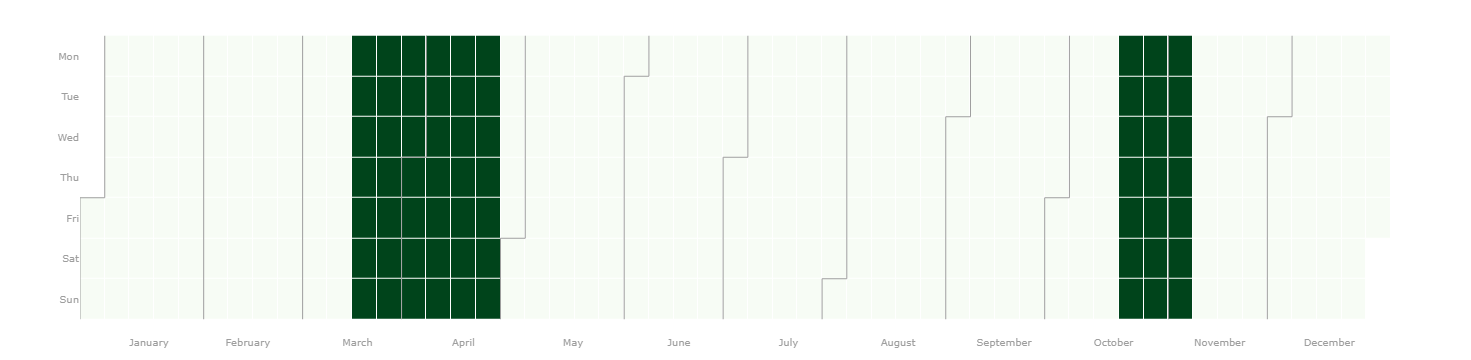

In [5]:
calendar = my_methods.manuring_periods(year, mais_week, rice_week, cereal_week)

In [6]:
# With this widget is possible to select from the dropdown list the required week
select_week = widgets.Dropdown(
    options=['mais_week', 'rice_week', 'cereal_week'],
    description='name:',
    disabled=False)
select_week

Dropdown(description='name:', options=('mais_week', 'rice_week', 'cereal_week'), value='mais_week')

In [7]:
# Select start and end date of the corresponding selected week using data from .csv files:
start_date = calendar[date[select_week.value][0]][0]
end_date = calendar[date[select_week.value][-1]][-1]
print("For", select_week.value, "the starting date is", start_date,"and the ending date is" , end_date)
start_date_dt = datetime.strptime(calendar[date[select_week.value][0]][0], '%Y-%m-%d')
end_date_dt = datetime.strptime(calendar[date[select_week.value][-1]][-1], '%Y-%m-%d')+timedelta(days=1) #increase 1 day to select data from arpa sensor correctly

For mais_week the starting date is 2021-03-15 and the ending date is 2021-04-04


In [8]:
start_date = str(start_date_dt)[0:10]
end_date = str(end_date_dt)[0:10]

In [9]:
date_object = datetime.strptime(start_date, '%Y-%m-%d').date()
year = str(date_object.year) #select the year

In [10]:
# # Use only for current year data request using API (data for years different from current one are not available)
# start_date_api = '"2022-01-01"'
# end_date_api = '"2022-01-03"'

In [11]:
# Key and app token for Socrata API
f = open('keys.json')
keys = json.load(f)

In [12]:
threshold = 4

---

# Import stations and sensor type from ARPA API

Import sensors description and position from the API: https://www.dati.lombardia.it/Ambiente/Stazioni-qualit-dell-aria/ib47-atvt

In [13]:
arpa_domain = "www.dati.lombardia.it"
st_descr = "ib47-atvt"

client = Socrata(arpa_domain, app_token = keys['arpa_token']) 
results = client.get_all(st_descr)

In [14]:
air_st_descr = pd.DataFrame(results)
air_st_descr["idsensore"] = air_st_descr["idsensore"].astype(int)

- - - 

<a id='aq_data_api'></a>
# Import air quality data from ARPA API

Skip to [air quality import from .csv](#aq_data_csv) data if required. The API works for current year data only.

In [ ]:
arpa_domain = "www.dati.lombardia.it"
dati = "nicp-bhqi" #change this depending on the dataset (check Open Data Lombardia datasets)

In [ ]:
client = Socrata(arpa_domain, app_token = "riTLzYVRVdDaQtUkxDDaHRgJi")

In [ ]:
date_query = "data > {} and data < {}".format(start_date_api,end_date_api)
date_query

In [ ]:
results = client.get(dati, where=date_query, limit=5000000000)

In [ ]:
aq_data = pd.DataFrame(results)

In [ ]:
aq_data['data'] =  pd.to_datetime(aq_data['data'], format='%Y/%m/%d %H:%M:%S')

In [ ]:
aq_data = aq_data.astype({"idsensore": int,"valore": float})

- - -

<a id='aq_data_csv'></a>
# Import air quality data from .csv

Go back to [air quality import from API](#aq_data_api) data if required. Used to access data from past years (not current one).

Example using air quality data 2020 from ARPA stations: https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria-2020/88sp-5tmj

Download the .csv data for the selected year in a zip folder. Read the .csv file and put it in a dataframe:

In [15]:
csv_url = my_methods.AQ_sensor(year)
r = requests.get(csv_url, allow_redirects=True)

In [16]:
DL_zip = open('aq_'+str(year)+'.zip', 'wb').write(r.content)
archive = zipfile.ZipFile('aq_'+str(year)+'.zip', 'r')
data = archive.open(str(year)+'.csv')

In [17]:
aq_data=pd.read_csv(data)
aq_data

IdSensore                 Data  Valore Stato  idOperatore
0             5504  01/01/2021 00:00:00 -9999.0   NaN            1
1             5832  01/01/2021 00:00:00 -9999.0   NaN            1
2             6328  01/01/2021 00:00:00 -9999.0   NaN            1
3             5507  01/01/2021 00:00:00    85.5    VA            1
4             5517  01/01/2021 00:00:00    67.6    VA            1
...            ...                  ...     ...   ...          ...
2656927      12020  31/12/2021 23:00:00     1.3    VA            1
2656928      20032  31/12/2021 23:00:00    61.6    VA            1
2656929      20034  31/12/2021 23:00:00    31.7    VA            1
2656930      20154  31/12/2021 23:00:00     2.5    VA            1
2656931      20216  31/12/2021 23:00:00     1.3    VA            1

[2656932 rows x 5 columns]

Rename columns:

In [18]:
aq_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)

Set date format:

In [19]:
aq_data['data'] =  pd.to_datetime(aq_data['data'], format='%d/%m/%Y %H:%M:%S')

In [20]:
aq_data

idsensore                data  valore stato  idoperatore
0             5504 2021-01-01 00:00:00 -9999.0   NaN            1
1             5832 2021-01-01 00:00:00 -9999.0   NaN            1
2             6328 2021-01-01 00:00:00 -9999.0   NaN            1
3             5507 2021-01-01 00:00:00    85.5    VA            1
4             5517 2021-01-01 00:00:00    67.6    VA            1
...            ...                 ...     ...   ...          ...
2656927      12020 2021-12-31 23:00:00     1.3    VA            1
2656928      20032 2021-12-31 23:00:00    61.6    VA            1
2656929      20034 2021-12-31 23:00:00    31.7    VA            1
2656930      20154 2021-12-31 23:00:00     2.5    VA            1
2656931      20216 2021-12-31 23:00:00     1.3    VA            1

[2656932 rows x 5 columns]

Select date range:

In [21]:
mask = (aq_data.data >= start_date) & (aq_data.data <= end_date)
aq_data = aq_data.loc[mask]

In [22]:
aq_data

idsensore       data  valore stato  idoperatore
513505       5814 2021-03-15 -9999.0   NaN            1
513506       9857 2021-03-15 -9999.0   NaN            1
513507       9860 2021-03-15 -9999.0   NaN            1
513508       9861 2021-03-15 -9999.0   NaN            1
513509      30162 2021-03-15 -9999.0   NaN            1
...           ...        ...     ...   ...          ...
668809      20488 2021-04-05     5.8    VA            1
668810      20492 2021-04-05     1.4    VA            1
668811      29041 2021-04-05     0.4    VA            1
668812      30158 2021-04-05     6.0    VA            1
668813      30166 2021-04-05     0.3    VA            1

[155309 rows x 5 columns]

- - -

# Air quality data processing

Drop "stato" and "idoperatore" columns and select valid values different from -9999:

In [23]:
aq_data = aq_data.drop(columns=['stato', 'idoperatore'])
aq_data = aq_data[aq_data.valore.astype(float) != -9999]

Get the unique sensor type names:

In [24]:
air_st_descr.nometiposensore.unique()

array(['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto',
       'Biossido di Zolfo', 'Particelle sospese PM2.5', 'Benzene',
       'Ozono', 'PM10 (SM2005)', 'Particolato Totale Sospeso',
       'Ammoniaca', 'Nikel', 'Arsenico', 'Cadmio', 'Piombo',
       'Benzo(a)pirene', 'BlackCarbon', 'Monossido di Azoto', 'PM10'],
      dtype=object)

In [25]:
sensor_sel = ['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto','Ozono',
       'Biossido di Zolfo', 'Particelle sospese PM2.5','Ammoniaca','PM10 (SM2005)']

Join sensors description and information with the mean value:

In [26]:
aq_table = pd.merge(aq_data, air_st_descr, on='idsensore')

Select sensors adding their names to the list:

In [27]:
aq_table['nometiposensore'].astype(str)
aq_table = aq_table[aq_table['nometiposensore'].isin(sensor_sel)]

In [28]:
pm25_st = aq_table.loc[aq_table['nometiposensore'] == 'Particelle sospese PM2.5']
co_st = aq_table.loc[aq_table['nometiposensore'] == 'Monossido di Carbonio']
no2_st = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Azoto']
so2_st = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Zolfo']
nh3_st = aq_table.loc[aq_table['nometiposensore'] == 'Ammoniaca']
nox_st = aq_table.loc[aq_table['nometiposensore'] == 'Ossidi di Azoto']
pm10_st = aq_table.loc[aq_table['nometiposensore'] == 'PM10 (SM2005)']
o3_st = aq_table.loc[aq_table['nometiposensore'] == 'Ozono']

Z-Test to remove outliers and calculate mean:

In [29]:
pm25_st['zscore'] = np.abs(stats.zscore(pm25_st['valore'], nan_policy='propagate'))
pm25_st = pm25_st[pm25_st.zscore < threshold]
pm25_st = pm25_st.groupby(['idsensore'],as_index=False).mean()
pm25_st = pd.merge(pm25_st, air_st_descr, on='idsensore')

In [30]:
co_st['zscore'] = np.abs(stats.zscore(co_st['valore'], nan_policy='propagate'))
co_st = co_st[co_st.zscore < threshold]
co_st = co_st.groupby(['idsensore'],as_index=False).mean()
co_st = pd.merge(co_st, air_st_descr, on='idsensore')

In [31]:
no2_st['zscore'] = np.abs(stats.zscore(no2_st['valore'], nan_policy='propagate'))
no2_st = no2_st[no2_st.zscore < threshold]
no2_st = no2_st.groupby(['idsensore'],as_index=False).mean()
no2_st = pd.merge(no2_st, air_st_descr, on='idsensore')

In [32]:
so2_st['zscore'] = np.abs(stats.zscore(so2_st['valore'], nan_policy='propagate'))
so2_st = so2_st[so2_st.zscore < threshold]
so2_st = so2_st.groupby(['idsensore'],as_index=False).mean()
so2_st = pd.merge(so2_st, air_st_descr, on='idsensore')

In [33]:
nh3_st['zscore'] = np.abs(stats.zscore(nh3_st['valore'], nan_policy='propagate'))
nh3_st = nh3_st[nh3_st.zscore < threshold]
nh3_st = nh3_st.groupby(['idsensore'],as_index=False).mean()
nh3_st = pd.merge(nh3_st, air_st_descr, on='idsensore')

In [34]:
nox_st['zscore'] = np.abs(stats.zscore(nox_st['valore'], nan_policy='propagate'))
nox_st = nox_st[nox_st.zscore < threshold]
nox_st = nox_st.groupby(['idsensore'],as_index=False).mean()
nox_st = pd.merge(nox_st, air_st_descr, on='idsensore')

In [35]:
pm10_st['zscore'] = np.abs(stats.zscore(pm10_st['valore'], nan_policy='propagate'))
pm10_st = pm10_st[pm10_st.zscore < threshold]
pm10_st = pm10_st.groupby(['idsensore'],as_index=False).mean()
pm10_st = pd.merge(pm10_st, air_st_descr, on='idsensore')

In [36]:
o3_st['zscore'] = np.abs(stats.zscore(o3_st['valore'], nan_policy='propagate'))
o3_st = o3_st[o3_st.zscore < threshold]
o3_st = o3_st.groupby(['idsensore'],as_index=False).mean()
o3_st = pd.merge(o3_st, air_st_descr, on='idsensore')

Save sensors separately and create a .gpkg file for each one:

In [37]:
pm25_gdf = gpd.GeoDataFrame(pm25_st, geometry=gpd.points_from_xy(pm25_st.lng, pm25_st.lat))
pm25_gdf = pm25_gdf.set_crs('epsg:4326')
co_gdf = gpd.GeoDataFrame(co_st, geometry=gpd.points_from_xy(co_st.lng, co_st.lat))
co_gdf = co_gdf.set_crs('epsg:4326')
no2_gdf = gpd.GeoDataFrame(no2_st, geometry=gpd.points_from_xy(no2_st.lng, no2_st.lat))
no2_gdf = no2_gdf.set_crs('epsg:4326')
so2_gdf = gpd.GeoDataFrame(so2_st, geometry=gpd.points_from_xy(so2_st.lng, so2_st.lat))
so2_gdf = so2_gdf.set_crs('epsg:4326')
nh3_gdf = gpd.GeoDataFrame(nh3_st, geometry=gpd.points_from_xy(nh3_st.lng, nh3_st.lat))
nh3_gdf = nh3_gdf.set_crs('epsg:4326')
nox_gdf = gpd.GeoDataFrame(nox_st, geometry=gpd.points_from_xy(nox_st.lng, nox_st.lat))
nox_gdf = nox_gdf.set_crs('epsg:4326')
pm10_gdf = gpd.GeoDataFrame(pm10_st, geometry=gpd.points_from_xy(pm10_st.lng, pm10_st.lat))
pm10_gdf = pm10_gdf.set_crs('epsg:4326')
o3_gdf = gpd.GeoDataFrame(o3_st, geometry=gpd.points_from_xy(o3_st.lng, o3_st.lat))
o3_gdf = o3_gdf.set_crs('epsg:4326')

Create a **temp** folder:

In [38]:
pm25_gdf.to_file(cwd+"/temp/pm25_st.gpkg", driver="GPKG")
co_gdf.to_file(cwd+"/temp/co_st.gpkg", driver="GPKG")
no2_gdf.to_file(cwd+"/temp/no2_st.gpkg", driver="GPKG")
so2_gdf.to_file(cwd+"/temp/so2_st.gpkg", driver="GPKG")
nh3_gdf.to_file(cwd+"/temp/nh3_st.gpkg", driver="GPKG")
nox_gdf.to_file(cwd+"/temp/nox_st.gpkg", driver="GPKG")
pm10_gdf.to_file(cwd+"/temp/pm10_st.gpkg", driver="GPKG")
o3_gdf.to_file(cwd+"/temp/o3_st.gpkg", driver="GPKG")

- - -

# Import meteorological stations from ARPA API

https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo-2020/erjn-istm

In [39]:
arpa_domain = "www.dati.lombardia.it"
m_st_descr = "nf78-nj6b"
client = Socrata(arpa_domain, app_token = "riTLzYVRVdDaQtUkxDDaHRgJi")
results = client.get_all(m_st_descr)

In [40]:
meteo_st_descr = pd.DataFrame(results)
meteo_st_descr["idsensore"] = meteo_st_descr["idsensore"].astype(int)

In [41]:
meteo_st_descr

idsensore           tipologia unit_dimisura idstazione  \
0           100      Precipitazione            mm         52   
1           101        Altezza Neve            cm         52   
2         10373      Precipitazione            mm        687   
3         10376      Precipitazione            mm        706   
4         10377         Temperatura            °C        706   
...         ...                 ...           ...        ...   
1257         99         Temperatura            °C         52   
1258       9933      Precipitazione            mm        677   
1259       9935  Radiazione Globale          W/m²        677   
1260       9938         Temperatura            °C        677   
1261       9939    Umidità Relativa             %        677   

                      nomestazione quota provincia                datastart  \
0               Grosio Diga Fusino  1220        SO  2002-01-01T00:00:00.000   
1               Grosio Diga Fusino  1220        SO  2001-12-01T00:00:00.000   
2                   Ferno v.Di Dio   215        VA  2007-08-13T00:00:00.000   
3                     Lecco v.Sora   272        LC  2008-07-22T00:00:00.000   
4                     Lecco v.Sora   272        LC  2008-07-22T00:00:00.000   
...                            ...   ...       ...                      ...   
1257            Grosio Diga Fusino  1220        SO  2001-12-01T00:00:00.000   
1258  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1259  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1260  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1261  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   

     storico cgb_nord cgb_est                 lng                 lat  \
0          N  5131141  595908  10.245970197827939  46.327055775545546   
1          N  5131141  595908  10.245970197827939  46.327055775545546   
2          N  5051773  481053   8.756970445453431   45.61924377994763   
3          N  5078987  531045   9.399950344681852   45.86374884127965   
4          N  5078987  531045   9.399950344681852   45.86374884127965   
...      ...      ...     ...                 ...                 ...   
1257       N  5131141  595908  10.245970197827939  46.327055775545546   
1258       N  4999315  582066  10.043836158369393   45.14254063221695   
1259       N  4999315  582066  10.043836158369393   45.14254063221695   
1260       N  4999315  582066  10.043836158369393   45.14254063221695   
1261       N  4999315  582066  10.043836158369393   45.14254063221695   

                                               location  \
0     {'latitude': '46.327055775545546', 'longitude'...   
1     {'latitude': '46.327055775545546', 'longitude'...   
2     {'latitude': '45.61924377994763', 'longitude':...   
3     {'latitude': '45.86374884127965', 'longitude':...   
4     {'latitude': '45.86374884127965', 'longitude':...   
...                                                 ...   
1257  {'latitude': '46.327055775545546', 'longitude'...   
1258  {'latitude': '45.14254063221695', 'longitude':...   
1259  {'latitude': '45.14254063221695', 'longitude':...   
1260  {'latitude': '45.14254063221695', 'longitude':...   
1261  {'latitude': '45.14254063221695', 'longitude':...   

     :@computed_region_6hky_swhk :@computed_region_ttgh_9sm5 datastop  
0                              3                           3      NaN  
1                              3                           3      NaN  
2                              1                           1      NaN  
3                             10                          10      NaN  
4                             10                          10      NaN  
...                          ...                         ...      ...  
1257                           3                           3      NaN  
1258                           8                           8      NaN  
1259                           8                      

- - -

<a id='meteo_data_api'></a>
# Import meteorological data from API

Skip to [meteorological data import from .csv](#meteo_data_csv) data if required. The API works for current month data only.

In [42]:
arpa_domain = "www.dati.lombardia.it"
dati = "647i-nhxk" #change this depending on the dataset (check Open Data Lombardia datasets)

In [43]:
client = Socrata(arpa_domain, app_token = keys['arpa_token']) #insert your arpa_token

The date must be changed from the following request:

In [ ]:
date_query = "data > {} and data < {}".format(start_date_api,end_date_api)
date_query

In [ ]:
results = client.get(dati, where=date_query, limit=5000000000)

In [ ]:
meteo_data = pd.DataFrame(results)

In [ ]:
meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%Y/%m/%d %H:%M:%S')

In [ ]:
meteo_data = meteo_data.astype({"idsensore": int,"valore": float})

<a id='meteo_data_csv'></a>
# Import meteorological data from ARPA .csv file

Go back to [meteorological data import from API](#meteo_data_api) data if required. Used to access data from past years (not current one).

Download the .csv data for the selected year in a zip folder. Read the .csv file and put it in a dataframe:

In [44]:
csv_url = my_methods.meteo_sensor(year)
r2 = requests.get(csv_url, allow_redirects=True)

In [45]:
DL_zip = open('meteo_'+str(year)+'.zip', 'wb').write(r2.content)
archive = zipfile.ZipFile('meteo_'+str(year)+'.zip', 'r')
data = archive.open(str(year)+'.csv')

In [46]:
meteo_data = pd.read_csv(data, dtype={"IdSensore": int,"Valore": float, "Stato": str, "idOperatore":str})

Rename columns:

In [47]:
meteo_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)

Set date format:

In [48]:
meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%d/%m/%Y %H:%M:%S')

Filter date range:

In [49]:
mask = (meteo_data.data >= start_date) & (meteo_data.data < end_date)
meteo_data = meteo_data.loc[mask]

- - -

# Meteorological data processing 

Drop "stato", "idoperatore" columns and select valid data different from -9999:

In [50]:
meteo_data = meteo_data.drop(columns=['stato', 'idoperatore'])
meteo_data = meteo_data[meteo_data.valore.astype(float) != -9999]

Get sensors unique types:

In [51]:
meteo_st_descr.tipologia.unique()

array(['Precipitazione', 'Altezza Neve', 'Temperatura',
       'Umidità Relativa', 'Radiazione Globale', 'Direzione Vento',
       'Velocità Vento', 'Livello Idrometrico'], dtype=object)

Select sensors adding to the following list:

In [52]:
m_sensor_sel = ['Precipitazione','Temperatura','Umidità Relativa','Direzione Vento','Velocità Vento', 'Radiazione Globale']

Join sensors description and information:

In [53]:
meteo_table = pd.merge(meteo_data, meteo_st_descr, on = 'idsensore')

Select sensor by type:

In [54]:
meteo_table['tipologia'].astype(str)
meteo_table = meteo_table[meteo_table['tipologia'].isin(m_sensor_sel)]

In [55]:
temp_st = meteo_table.loc[meteo_table['tipologia'] == 'Temperatura']
prec_st = meteo_table.loc[meteo_table['tipologia'] == 'Precipitazione']
air_hum_st = meteo_table.loc[meteo_table['tipologia'] == 'Umidità Relativa']
wind_dir_st = meteo_table.loc[meteo_table['tipologia'] == 'Direzione Vento']
wind_speed_st = meteo_table.loc[meteo_table['tipologia'] == 'Velocità Vento']
rad_glob_st = meteo_table.loc[meteo_table['tipologia'] == 'Radiazione Globale']

Calculate Z-Score to remove outliers and calculate mean:

In [56]:
temp_st['zscore'] = np.abs(stats.zscore(temp_st['valore'], nan_policy='propagate'))
temp_st = temp_st[temp_st.zscore < threshold]
temp_st = temp_st.groupby(['idsensore'],as_index=False).mean()
temp_st = pd.merge(temp_st, meteo_st_descr, on = 'idsensore')

In [57]:
# precipitation values less than 100 to remove outliers
prec_st = prec_st[prec_st.valore < 100]
prec_st = prec_st.groupby(['idsensore'],as_index=False).mean()
prec_st = pd.merge(prec_st, meteo_st_descr, on = 'idsensore')

In [58]:
air_hum_st['zscore'] = np.abs(stats.zscore(air_hum_st['valore'], nan_policy='propagate'))
air_hum_st = air_hum_st[air_hum_st.zscore < threshold]
air_hum_st = air_hum_st.groupby(['idsensore'],as_index=False).mean()
air_hum_st = pd.merge(air_hum_st, meteo_st_descr, on = 'idsensore')

In [59]:
wind_dir_st['zscore'] = np.abs(stats.zscore(wind_dir_st['valore'], nan_policy='propagate'))
wind_dir_st = wind_dir_st[wind_dir_st.zscore < threshold]
wind_dir_st = wind_dir_st.groupby(['idsensore'],as_index=False).mean()
wind_dir_st = pd.merge(wind_dir_st, meteo_st_descr, on = 'idsensore')

In [60]:
wind_speed_st['zscore'] = np.abs(stats.zscore(wind_speed_st['valore'], nan_policy='propagate'))
wind_speed_st = wind_speed_st[wind_speed_st.zscore < threshold]
wind_speed_st = wind_speed_st.groupby(['idsensore'],as_index=False).mean()
wind_speed_st = pd.merge(wind_speed_st, meteo_st_descr, on = 'idsensore')

In [61]:
rad_glob_st['zscore'] = np.abs(stats.zscore(rad_glob_st['valore'], nan_policy='propagate'))
rad_glob_st = rad_glob_st[rad_glob_st.zscore < threshold]
rad_glob_st = rad_glob_st.groupby(['idsensore'],as_index=False).mean()
rad_glob_st = pd.merge(rad_glob_st, meteo_st_descr, on = 'idsensore')

Save sensors separately and create a .gpkg file for each one:

In [62]:
temp_gdf = gpd.GeoDataFrame(temp_st, geometry=gpd.points_from_xy(temp_st.lng, temp_st.lat))
temp_gdf = temp_gdf.set_crs('epsg:4326')

In [63]:
prec_gdf = gpd.GeoDataFrame(prec_st, geometry=gpd.points_from_xy(prec_st.lng, prec_st.lat))
prec_gdf = prec_gdf.set_crs('epsg:4326')

In [64]:
air_hum_gdf = gpd.GeoDataFrame(air_hum_st, geometry=gpd.points_from_xy(air_hum_st.lng, air_hum_st.lat))
air_hum_gdf = air_hum_gdf.set_crs('epsg:4326')

In [65]:
wind_dir_gdf = gpd.GeoDataFrame(wind_dir_st, geometry=gpd.points_from_xy(wind_dir_st.lng, wind_dir_st.lat))
wind_dir_gdf = wind_dir_gdf.set_crs('epsg:4326')

In [66]:
wind_speed_gdf = gpd.GeoDataFrame(wind_speed_st, geometry=gpd.points_from_xy(wind_speed_st.lng, wind_speed_st.lat))
wind_speed_gdf = wind_speed_gdf.set_crs('epsg:4326')

In [67]:
rad_glob_gdf = gpd.GeoDataFrame(rad_glob_st, geometry=gpd.points_from_xy(rad_glob_st.lng, rad_glob_st.lat))
rad_glob_gdf = rad_glob_gdf.set_crs('epsg:4326')

In [68]:
temp_gdf.to_file(cwd+"/temp/temp_st.gpkg", driver="GPKG")
prec_gdf.to_file(cwd+"/temp/prec_st.gpkg", driver="GPKG")
air_hum_gdf.to_file(cwd+"/temp/air_hum_st.gpkg", driver="GPKG")
wind_dir_gdf.to_file(cwd+"/temp/wind_dir_st.gpkg", driver="GPKG")
wind_speed_gdf.to_file(cwd+"/temp/wind_speed_st.gpkg", driver="GPKG")
rad_glob_gdf.to_file(cwd+"/temp/rad_glob_st.gpkg", driver="GPKG")

# Sensor interpolation using Radial Basis Functions (RBF)

In [69]:
from osgeo import gdal
from osgeo import ogr
import rasterio as rio
from rasterio.transform import Affine
from rasterio.crs import CRS
import matplotlib.pyplot as plt

In [70]:
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [71]:
pm25_gdf = pm25_gdf.to_crs('epsg:32632')
co_gdf = co_gdf.to_crs('epsg:32632')
no2_gdf = no2_gdf.to_crs('epsg:32632')
so2_gdf = so2_gdf.to_crs('epsg:32632')
nh3_gdf = nh3_gdf.to_crs('epsg:32632')
nox_gdf = nox_gdf.to_crs('epsg:32632')
pm10_gdf = pm10_gdf.to_crs('epsg:32632')
o3_gdf = o3_gdf.to_crs('epsg:32632')

In [72]:
temp_gdf = temp_gdf.to_crs('epsg:32632')
prec_gdf = prec_gdf.to_crs('epsg:32632')
air_hum_gdf = air_hum_gdf.to_crs('epsg:32632')
wind_dir_gdf = wind_dir_gdf.to_crs('epsg:32632')
wind_speed_gdf = wind_speed_gdf.to_crs('epsg:32632')
rad_glob_gdf = rad_glob_gdf.to_crs('epsg:32632')

In [73]:
bb = gdal.Open(cwd+"/bounding_box/bounding_box_buffer20_raster_32632.tif")
gt = bb.GetGeoTransform()

In [74]:
ulx = gt[0]
uly = gt[3]
resx = gt[1]
resy = gt[5]
xsize = bb.RasterXSize
ysize = bb.RasterYSize
lrx = ulx + xsize * resx
lry = uly + ysize * resy

In [75]:
xsize, ysize

(412, 263)

In [76]:
ulx, uly

(437922.9288, 5188927.2639)

In [77]:
lrx, lry

(720885.7822, 4923700.7934)

In [78]:
rRes = 3000

In [79]:
# For now interpolate all the ARPA/ESA stations. 
# Must implement a check if number of station over the Lombardy region is too low -> don't interpolate

In [80]:
xRange = np.arange(ulx,lrx+rRes,rRes)
yRange = np.arange(lry,uly+rRes,rRes)
gridX,gridY = np.meshgrid(xRange, yRange)

In [81]:
aq_dict = {'pm25_gdf':pm25_gdf, 'co_gdf':co_gdf, 'no2_gdf':no2_gdf, 'so2_gdf':so2_gdf,
           'nh3_gdf':nh3_gdf, 'nox_gdf':nox_gdf, 'pm10_gdf':pm10_gdf, 'o3_gdf':o3_gdf}

meteo_dict = {'temp_gdf':temp_gdf, 'prec_gdf':prec_gdf, 'air_hum_gdf':air_hum_gdf, 'wind_dir_gdf':wind_dir_gdf,
           'wind_speed_gdf':wind_speed_gdf, 'rad_glob_gdf':rad_glob_gdf}

pm25_gdf


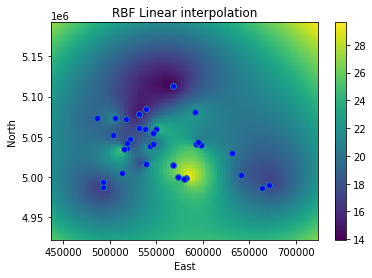

co_gdf


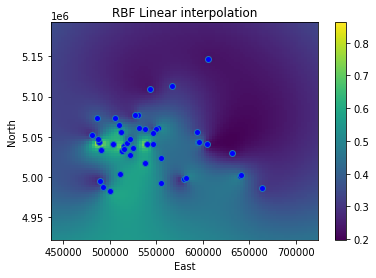

no2_gdf


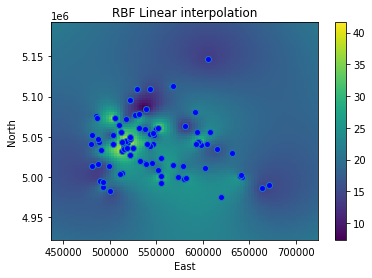

so2_gdf


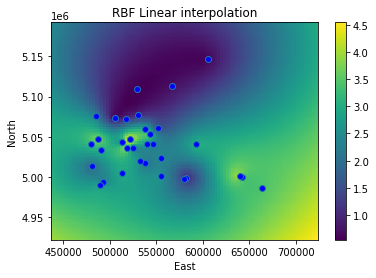

nh3_gdf


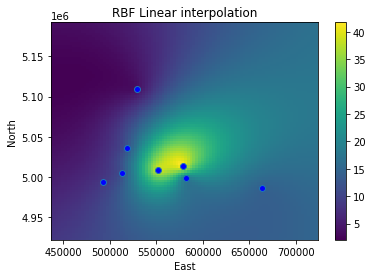

nox_gdf


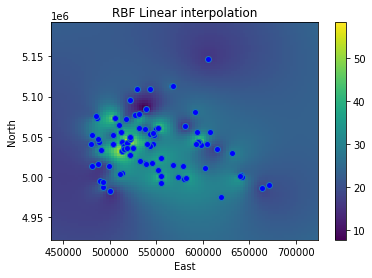

pm10_gdf


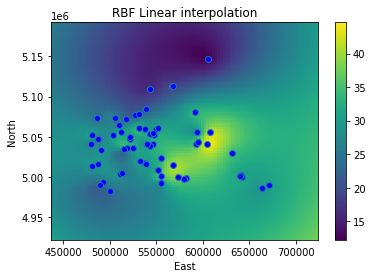

o3_gdf


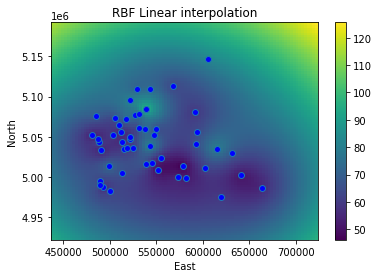

In [82]:
for key in aq_dict:
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear')
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o', markerfacecolor='blue');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Linear interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
    

temp_gdf


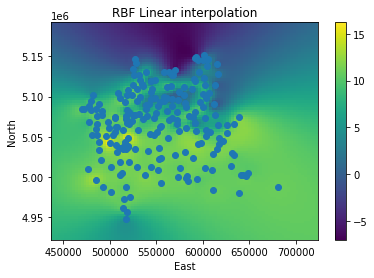

prec_gdf


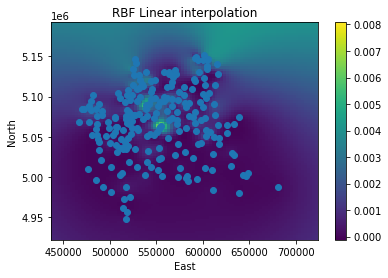

air_hum_gdf


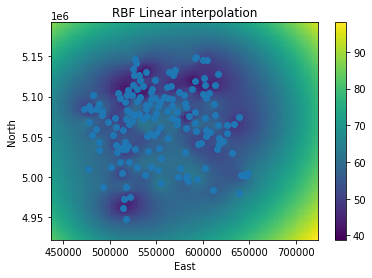

wind_dir_gdf


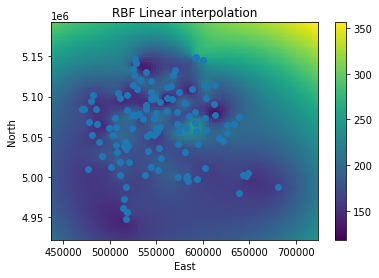

wind_speed_gdf


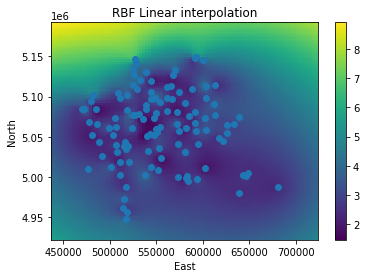

rad_glob_gdf


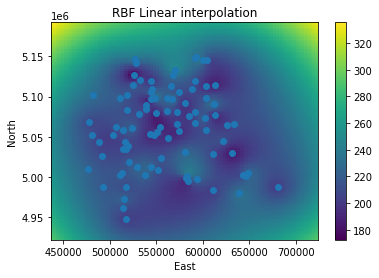

In [83]:
for key in meteo_dict:
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear')
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Linear interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)

Statistics, Points Sampling with stations positions and rasters:

Data name : pm25_gdf
Max value from stations: 30.272727272727273
Max value from interpolated raster: 29.02315979425009
Min value from stations: 13.863636363636363
Min value from interpolated raster: 13.955387729921483
RMSE max: 1.3370435084282484
RMSE mean : 0.3401501635335866


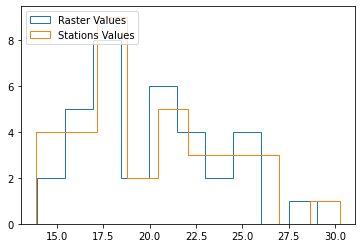

----------------------------------
Data name : co_gdf
Max value from stations: 0.9062111801242236
Max value from interpolated raster: 0.8621926646395686
Min value from stations: 0.2047808764940239
Min value from interpolated raster: 0.2279313796125635
RMSE max: 0.15173204932832685
RMSE mean : 0.022885248834295976


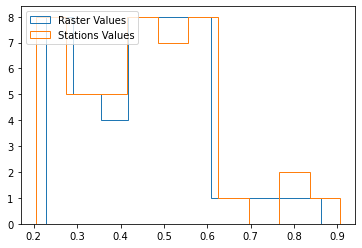

----------------------------------
Data name : no2_gdf
Max value from stations: 44.06283783783784
Max value from interpolated raster: 41.61853872512859
Min value from stations: 6.505940594059406
Min value from interpolated raster: 7.401405022033259
RMSE max: 15.865071672049194
RMSE mean : 1.3103774898674212


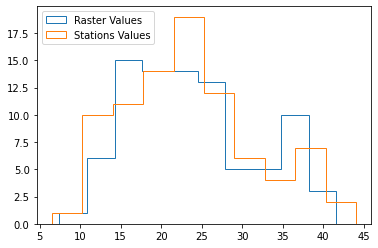

----------------------------------
Data name : so2_gdf
Max value from stations: 4.655888650963598
Max value from interpolated raster: 4.473937085689492
Min value from stations: 0.5523908523908524
Min value from interpolated raster: 0.5512964645479386
RMSE max: 0.3661976460214684
RMSE mean : 0.07603516747434139


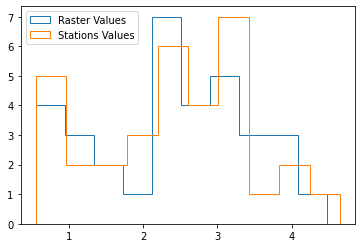

----------------------------------
Data name : nh3_gdf
Max value from stations: 42.31904761904762
Max value from interpolated raster: 41.3072127596297
Min value from stations: 3.4095238095238094
Min value from interpolated raster: 3.7295902193064023
RMSE max: 1.1763161466598149
RMSE mean : 0.4306072064626261


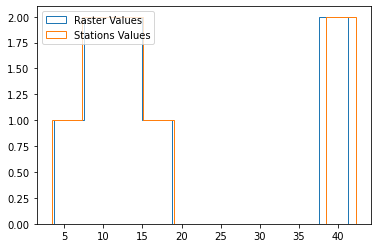

----------------------------------
Data name : nox_gdf
Max value from stations: 62.30457516339869
Max value from interpolated raster: 58.31022048227089
Min value from stations: 6.4675247524752475
Min value from interpolated raster: 7.781173189481422
RMSE max: 26.802508260268283
RMSE mean : 2.025738550052795


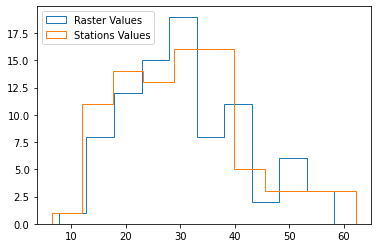

----------------------------------
Data name : pm10_gdf
Max value from stations: 45.0
Max value from interpolated raster: 43.65252199357599
Min value from stations: 12.095238095238095
Min value from interpolated raster: 12.540570122272129
RMSE max: 9.301084240399781
RMSE mean : 0.7538691340785116


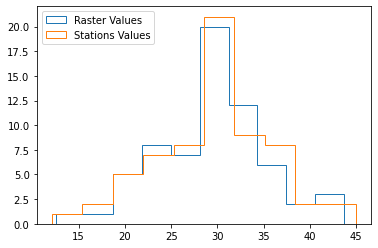

----------------------------------
Data name : o3_gdf
Max value from stations: 98.76712871287128
Max value from interpolated raster: 96.46179298888438
Min value from stations: 45.85460829493088
Min value from interpolated raster: 46.19626074009161
RMSE max: 3.5725801120114298
RMSE mean : 0.7880311239435096


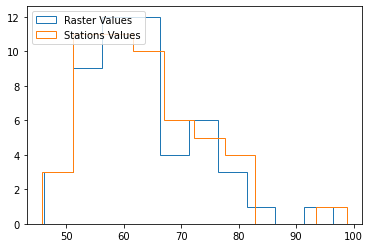

----------------------------------


In [84]:
for key in aq_dict:
    raster = rio.open(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif')
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    aq_dict[key].index = range(len(aq_dict[key]))
    coords = [(x,y) for x, y in zip(aq_dict[key].geometry.x,aq_dict[key].geometry.y)]
    aq_dict[key]['Raster Value'] = [x[0] for x in raster.sample(coords)]
    rmse = ((aq_dict[key]['Raster Value'] - aq_dict[key]['valore'])**2)**(1/2)
    print("Data name : {name}".format(name = key))
    print("Max value from stations: {value}".format(value = aq_dict[key]['valore'].max()))
    print("Max value from interpolated raster: {value}".format(value=aq_dict[key]['Raster Value'].max()))
    print("Min value from stations: {value}".format(value = aq_dict[key]['valore'].min()))
    print("Min value from interpolated raster: {value}".format(value=aq_dict[key]['Raster Value'].min()))
    print("RMSE max: {rmse}".format(rmse = rmse.max()))
    print("RMSE mean : {rmse}".format(rmse = rmse.mean()))
    plt.hist(aq_dict[key]['Raster Value'], label = 'Raster Values', histtype='step')
    plt.hist(aq_dict[key]['valore'], label = 'Stations Values', histtype='step')
    plt.legend(loc="upper left")
    plt.show()
    print("----------------------------------")
    

Data name : temp_gdf
Max value from stations: 17.113588850174217
Max value from interpolated raster: 16.211826590451295
Min value from stations: -6.926561450638012
Min value from interpolated raster: -6.6252405095162885
RMSE max: 2.8716424437222345
RMSE mean : 0.4004987160390125


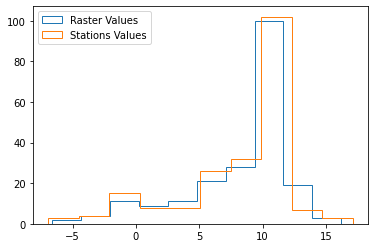

----------------------------------
Data name : prec_gdf
Max value from stations: 0.009325396825396825
Max value from interpolated raster: 0.007636549232361643
Min value from stations: 0.0
Min value from interpolated raster: -1.6857057153957244e-05
RMSE max: 0.0017906831706822335
RMSE mean : 0.0001466388525501803


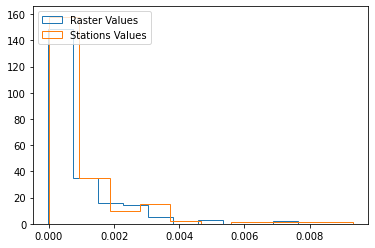

----------------------------------
Data name : air_hum_gdf
Max value from stations: 65.91051935163745
Max value from interpolated raster: 64.50752181632942
Min value from stations: 38.35666556400926
Min value from interpolated raster: 38.79913683537046
RMSE max: 4.5281019538470915
RMSE mean : 0.7210545352069163


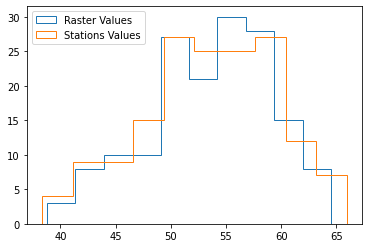

----------------------------------
Data name : wind_dir_gdf
Max value from stations: 265.8086666666667
Max value from interpolated raster: 257.3341445308713
Min value from stations: 110.95615486432825
Min value from interpolated raster: 118.28646232587414
RMSE max: 21.97525085453657
RMSE mean : 3.5824186950114325


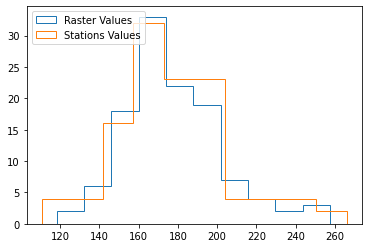

----------------------------------
Data name : wind_speed_gdf
Max value from stations: 6.67318711717052
Max value from interpolated raster: 6.036224081039165
Min value from stations: 1.320436507936508
Min value from interpolated raster: 1.4587199578302545
RMSE max: 1.4326366328636073
RMSE mean : 0.12792212132924655


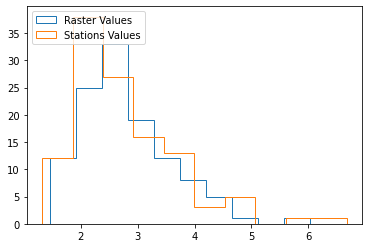

----------------------------------
Data name : rad_glob_gdf
Max value from stations: 250.56850235057087
Max value from interpolated raster: 249.73527807650697
Min value from stations: 166.5443414956982
Min value from interpolated raster: 172.48066080704666
RMSE max: 14.9478066952679
RMSE mean : 1.7985871377968152


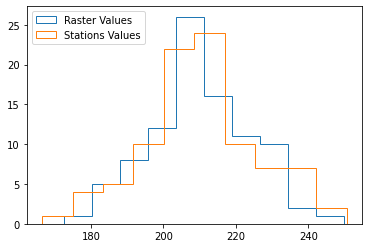

----------------------------------


In [85]:
for key in meteo_dict:
    raster = rio.open(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif')
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    meteo_dict[key].index = range(len(meteo_dict[key]))
    coords = [(x,y) for x, y in zip(meteo_dict[key].geometry.x, meteo_dict[key].geometry.y)]
    meteo_dict[key]['Raster Value'] = [x[0] for x in raster.sample(coords)]
    rmse = ((meteo_dict[key]['Raster Value'] - meteo_dict[key]['valore'])**2)**(1/2)
    print("Data name : {name}".format(name = key))
    print("Max value from stations: {value}".format(value = meteo_dict[key]['valore'].max()))
    print("Max value from interpolated raster: {value}".format(value=meteo_dict[key]['Raster Value'].max()))
    print("Min value from stations: {value}".format(value = meteo_dict[key]['valore'].min()))
    print("Min value from interpolated raster: {value}".format(value=meteo_dict[key]['Raster Value'].min()))
    print("RMSE max: {rmse}".format(rmse = rmse.max()))
    print("RMSE mean : {rmse}".format(rmse = rmse.mean()))
    plt.hist(meteo_dict[key]['Raster Value'], label = 'Raster Values', histtype='step')
    plt.hist(meteo_dict[key]['valore'], label = 'Stations Values', histtype='step')
    plt.legend(loc="upper left")
    plt.show()
    print("----------------------------------")
        

Kriging:

In [ ]:
# from pykrige.ok import OrdinaryKriging
# from pykrige.kriging_tools import write_asc_grid
# import pykrige.kriging_tools as kt

In [ ]:
# for key in aq_dict:
#     east = aq_dict[key].geometry.x
#     north = aq_dict[key].geometry.y
#     value = aq_dict[key][['valore']]
#     n_sensor = aq_dict[key].shape[0]  #VERIFICARE nlags in funzione del numero di sensori (defaul 6)
#     lag = int(math.sqrt(n_sensor))
    
#     OK = OrdinaryKriging(east, north,value, weight=True,nlags= lag ,variogram_model='power',coordinates_type='euclidean') #verbose=True, enable_plotting=False, weight=w
#     # print(UniversalKriging.__doc__ )
#     gridded, ss1 = OK.execute('grid', xRange, yRange)
#     transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)
#     rasterCrs = CRS.from_epsg(32632)
#     #definition, register and close of interpolated raster
#     interpRaster = rio.open(cwd +'/temp/aq_krig_'+key[:(len(key)-4)]+'.tif',
#                                     'w',
#                                     driver='GTiff',
#                                     height=gridded.shape[0],
#                                     width=gridded.shape[1],
#                                     count=1,
#                                     nodata = -9999,
#                                     dtype=gridded.dtype,
#                                     crs=rasterCrs,
#                                     transform=transform,
#                                     )
#     interpRaster.write(gridded, 1)
#     interpRaster.close()
#     #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
#     ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_krig_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
#                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
#     print(key)
#     plt.imshow(gridded)
#     plt.show()

In [ ]:
# for key in meteo_dict:
#     east = meteo_dict[key].geometry.x
#     north = meteo_dict[key].geometry.y
#     value = meteo_dict[key][['valore']]
#     n_sensor = meteo_dict[key].shape[0]  #VERIFICARE nlags in funzione del numero di sensori (defaul 6)
#     lag = int(math.sqrt(n_sensor))
    
#     OK = OrdinaryKriging(east, north, value, nlags= lag,
#                  weight=True, variogram_model='power',coordinates_type='euclidean') #verbose=True, enable_plotting=False, weight=w
#     # print(OrdinaryKriging.__doc__)
#     gridded, ss1 = OK.execute('grid', xRange, yRange)
#     transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)
#     rasterCrs = CRS.from_epsg(32632)
#     #definition, register and close of interpolated raster
#     interpRaster = rio.open(cwd +'/temp/meteo_krig_'+key[:(len(key)-4)]+'.tif',
#                                     'w',
#                                     driver='GTiff',
#                                     height= gridded.shape[0],
#                                     width= gridded.shape[1],
#                                     count=1,
#                                     nodata = -9999,
#                                     dtype=gridded.dtype,
#                                     crs=rasterCrs,
#                                     transform=transform,
#                                     )
#     interpRaster.write(gridded, 1)
#     interpRaster.close()
#     #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
#     ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_krig_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
#                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
#     print(key)
#     print(lag)
#     plt.imshow(gridded)
#     plt.show()

Notes:

In [ ]:
# INTERPOLATION USING GDAL
# pts = ogr.Open(cwd+'/temp/air_hum_st.gpkg', update = True)
# layer=pts.GetLayer()

# to generate a an interpolation using GDAL library
# pts = layer = None
# idw = gdal.Grid("idw.tif", (cwd+'/temp/air_hum_st.gpkg'), zfield="valore",
#                algorithm = "invdist", outputBounds = [ulx,uly,lrx,lry],
#                width = xsize, height = ysize)
# idw = None

# points = list(zip(air_hum_st.lng,air_hum_st.lat))

# gridded = griddata(points, value, (gridX,gridY), method='linear',fill_value=0)

# gridded = gridded.reshape((gridded.shape[0], gridded.shape[1]))

# plt.imshow(gridded)

In [ ]:
#Mask data using date range
#mask = (meteo_data['data'] >= start_date) & (meteo_data['data'] < end_date)
#meteo_data = meteo_data.loc[mask]
#meteo_data

In [ ]:
# print(list(arpa_df.columns))
# print(arpa_df['idsensore'].values)

In [ ]:
# results = client.get_all(dati, idsensore = "100", data='2022-01-20')
# results

In [ ]:
# arpa_df.loc[arpa_df['idsensore'] == "10377"]